In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyvista as pv

import imageio.v2 as iio
from io import BytesIO

import time

from acoustic_BEM.mesh import Mesh
from acoustic_BEM.integrators import (ElementIntegratorCollocation, 
                                ElementIntegratorGalerkin)
from acoustic_BEM.matrix_assembly import (CollocationAssembler, 
                                    GalerkinAssembler)
from acoustic_BEM.solve import BEMSolver

%load_ext autoreload
%autoreload 2

In [2]:
# data_repo = 'C:\\Users\\kristofc\\Doktorat\\Projekti\\Clanek_III\\Data_pokrov'
data_repo = 'D:\\Kristof Cufar\\Clanek_III\\Data_pokrov'

mesh = pv.read(f'{data_repo}\\Pokrov_smooth_decimated.vtk')
disp_BC = np.load(f'{data_repo}\\html_data\\mode_shape_1.npy')

nodes = mesh.points
elements = mesh.faces.reshape((-1, 4))[:, 1:4]

frequency = 240
c0 = 343
omega = 2 * np.pi * frequency
k = omega / c0
rho0 = 1.225

vel_BC = -1j * omega * disp_BC

# Get mesh dimensions
Lx = np.max(nodes[:, 0]) - np.min(nodes[:, 0])
Ly = np.max(nodes[:, 1]) - np.min(nodes[:, 1])
Lz = np.max(nodes[:, 2]) - np.min(nodes[:, 2])

char_length = np.max([Lx, Ly, Lz])

plane_extent = 5 * char_length
plane_pts = 200

# --- Build evaluation grid in x–z plane ---
xs = np.linspace(-plane_extent, plane_extent, plane_pts)
zs = np.linspace(-plane_extent, plane_extent, plane_pts)
XX, ZZ = np.meshgrid(xs, zs)
YY = np.zeros_like(XX)

field_pts = np.column_stack([XX.ravel(), YY.ravel(), ZZ.ravel()])

center = nodes.mean(axis=0)
r_exclude = 0.5 * char_length * 1.05

dist = np.linalg.norm(field_pts - center, axis=1)
mask = dist > r_exclude

field_pts_safe = field_pts[mask, :]

print(f'Mesh has {nodes.shape[0]} vertices and {elements.shape[0]} faces.')
print(f'Characteristic length: {char_length:.2f} m')
print(f'Wavenumber: {k:.2f} 1/m')
print(f'k*L = {k*char_length:.2f}')
print(f'Wavelength: {2*np.pi/k:.2f} m')
print(f'Velocity BC: {np.min(np.abs(vel_BC)):.4f} to {np.max(np.abs(vel_BC)):.4f} m/s')

# pl = pv.Plotter()
# pl.add_mesh(mesh, color='white', show_edges=True)
# pl.show()

Mesh has 1520 vertices and 2404 faces.
Characteristic length: 0.11 m
Wavenumber: 4.40 1/m
k*L = 0.50
Wavelength: 1.43 m
Velocity BC: 0.0000 to 2.7401 m/s


In [3]:
mesh = Mesh(mesh_nodes=nodes, 
            mesh_elements=elements, 
            Neumann_BC=vel_BC,
            Dirichlet_BC=None,
            frequency=frequency, 
            c0=c0, 
            rho0=rho0)
integrator = ElementIntegratorCollocation(k = mesh.k)
assembler = CollocationAssembler(mesh, integrator)
solver = BEMSolver(assembler=assembler)

In [4]:
t_start = time.time()
print("Assembling matrices...")
# mats = {
#     "S": assembler.assemble("S"),
#     "D": assembler.assemble("D"),
#     # Kp and N not needed for this solve
# }

mats_bm = {
    "S": assembler.assemble("S"),
    "D": assembler.assemble("D"),
    "Kp": assembler.assemble("Kp"),
    "N": assembler.assemble("NReg"),
}

t_assembly = time.time()
print(f"  ... done in {t_assembly - t_start:.2f} s.")

# --- solve BIE for Neumann BC (normal velocity) ---
print("Solving BIE...")
# phi_bnd = solver.solve_direct(matrices=mats)
phi_bnd = solver.solve_burton_miller(matrices=mats_bm,
                                     alpha = -1j/mesh.k)
t_solve = time.time()
print(f"  ... done in {t_solve - t_assembly:.2f} s.")

# --- Evaluate **potential** then convert to pressure
print("Evaluating field...")
phi_field = solver.evaluate_field(field_pts_safe, quad_order=3)
p_field = 1j * omega * rho0 * phi_field
p_full = np.full(field_pts.shape[0], np.nan, dtype=complex)
p_full[mask] = p_field
P_grid = p_full.reshape(XX.shape)
t_evaluate = time.time()
print(f"  ... done in {t_evaluate - t_solve:.2f} s.")

Assembling matrices...
  ... done in 262.62 s.
Solving BIE...
  ... done in 0.82 s.
Evaluating field...
  ... done in 67.70 s.


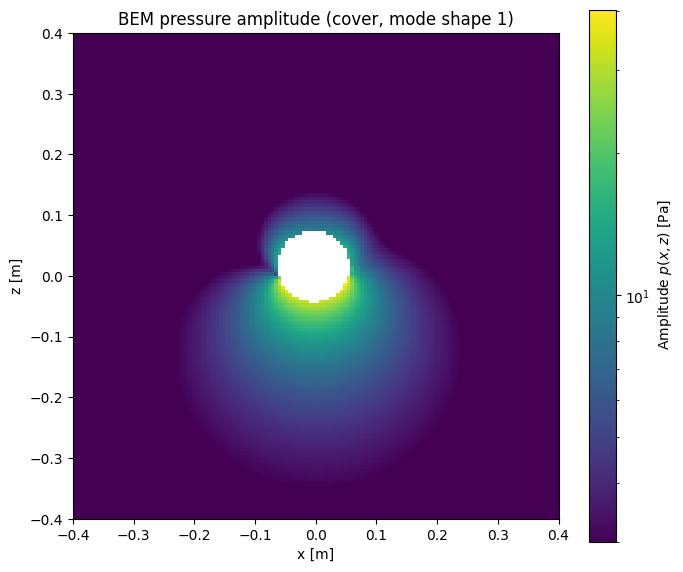

In [5]:
# --- Plot 2D heatmap of |p| ---
plt.figure(figsize=(7, 6))
plt.pcolormesh(XX, ZZ, np.abs(P_grid), 
               shading="auto", cmap="viridis", 
               norm= colors.LogNorm(vmin=3, vmax=np.nanmax(np.abs(P_grid))))
plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)
plt.colorbar(label=r" Amplitude $p(x,z)$ [Pa]")
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.title("BEM pressure amplitude (cover, mode shape 1)")
plt.gca().set_aspect("equal")
plt.tight_layout()

In [7]:
omega = 2 * np.pi * frequency
period = 2 * np.pi / omega
n_frames = 40

max_amp = np.nanmax(np.abs(P_grid))

frames = []
temp_writter = iio.get_writer('mode_1_BM_reg.gif', 
                              mode='I', 
                              duration=1,
                              loop=0)

with temp_writter as writer:
    for i in range(n_frames):
        t = i / n_frames * period
        p_inst = np.real(P_grid * np.exp(-1j * omega * t))

        fig, ax = plt.subplots(figsize=(7, 6))
        im = ax.imshow(
            p_inst,
            extent=[XX.min(), XX.max(), ZZ.min(), ZZ.max()],
            origin="lower",
            cmap="viridis",
            vmin = -max_amp,
            vmax = max_amp,
        )

        ax.set_xlabel("x [m]")
        ax.set_ylabel("z [m]")
        ax.set_aspect("equal")
        fig.colorbar(im, ax=ax, label="Pressure [Pa]")

        buffer = BytesIO()
        fig.savefig(buffer, format="png", bbox_inches="tight")
        buffer.seek(0)
        frame = iio.imread(buffer)
        writer.append_data(frame)
        plt.close(fig)

buffer.close()
writer.close()